In [71]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from rapidfuzz import process, fuzz

import re

# Import tools, unreasonably hard on windows due to no symlink support
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', )))
from tools.pdtools import bootstrap_ci

In [72]:
df_breach_arti  = pd.read_csv("../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",)
df_company      = pd.read_csv("../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv")
df_breach     = pd.read_csv("../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv")
#df_company[df_company['BreachMentioned'] != "False"].drop(['Date', 'Publication', 'Headline', 'URL', 'BreachMentioned', 'CompanyMentioned'], axis=1).drop_duplicates(subset=['organisation', 'breach_date', 'sector'], keep='first')

In [73]:
# Collapse some shittier size ranges into less shitty ones
SIZES = ['1 - 10', '11 - 50', '51 - 200', '201 - 500', '501 - 1000', '1001 - 5000', '5001 - 10000', '10001+']

# collapse_map = {
#     '1 - 10': '1 - 50',
#     '11 - 50': '1 - 50',
#     '51 - 200': '51 - 500',
#     '201 - 500': '51 - 500',
#     '501 - 1000': '501 - 5000',
#     '1001 - 5000': '501 - 5000',
#     '5001 - 10000': '5001+',
#     '10001+': '5001+',
# }

# df_company['size range'] = df_company['size range'].replace(collapse_map)
# df_breach['size range'] = df_breach['size range'].replace(collapse_map)

# SIZES = ['1 - 50', '51 - 500', '501 - 5000', '5001+']

In [74]:
# Bootstrap CI for the number of articles per industry
def calc_distrib(subdf):
    return subdf["size range"].value_counts() / subdf["size range"].count()

article_rates = bootstrap_ci(df_company, calc_distrib, frac=1, n=100)
breach_rates  = bootstrap_ci(df_breach, calc_distrib, frac=1, n=100)

In [75]:
# Convert each to a single number estimate
df = pd.merge(article_rates, breach_rates, left_index=True, right_index=True, suffixes=("_articles", "_breach"))

df["rate_articles"]   = df["count_articles"].apply(lambda x: np.mean(x))
df["rate_breach"] = df["count_breach"].apply(lambda x: np.mean(x))

df["error_articles"]   = df["count_articles"].apply(lambda x: x[1]-x[0])
df["error_breach"] = df["count_breach"].apply(lambda x: x[1]-x[0])

In [76]:
df_viz = pd.melt(
    df.reset_index(),
    id_vars=["size range"],
    value_vars=["rate_articles", "rate_breach"],
    var_name="Rate Type",
    value_name="Rate",
)

# pseudojoin on error bars
df_viz["Error"] = df_viz.apply(lambda x: df.loc[x["size range"]]["error_articles"] if x["Rate Type"] == "rate_articles" else df.loc[x["size range"]]["error_breach"], axis=1)

# Sort by size range
order     = SIZES + ['rate_breach', 'rate_articles']
df_viz = df_viz.sort_values(by=["size range", "Rate Type"], key=lambda x: [order.index(x) for x in x])

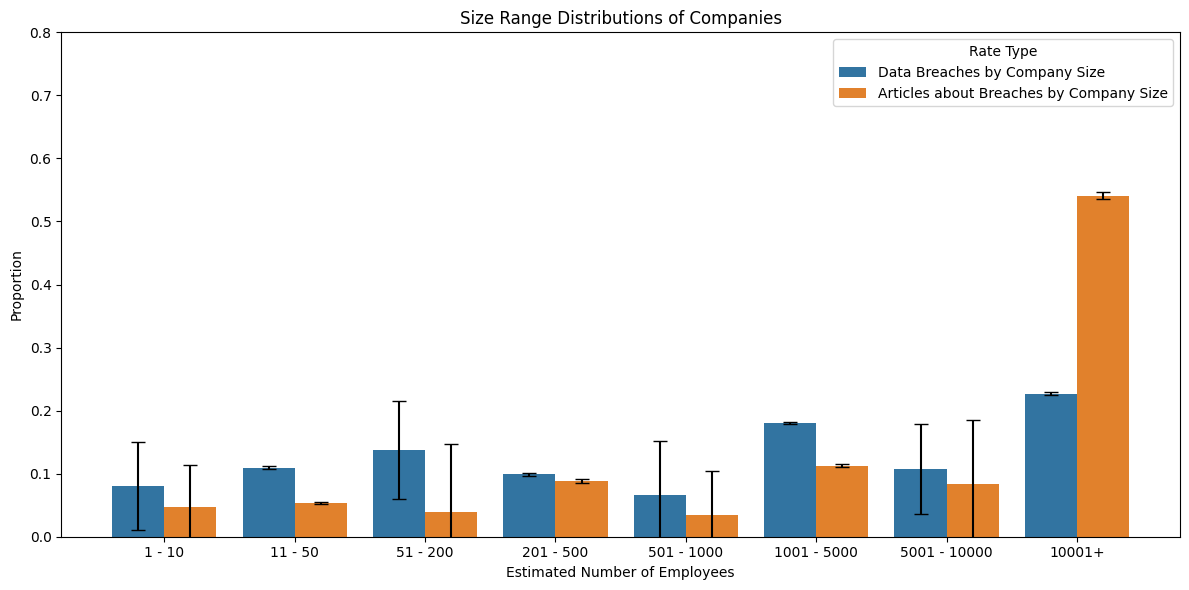

In [77]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=df_viz,
    x="size range",
    y="Rate",
    hue="Rate Type",
    #palette="muted",
    errorbar=None
)

# Add error bars manually
for i, bar in enumerate(list(barplot.patches)[:-2]):
    # Calculate position
    group_index = i // 2  # Each group (Industry) has 2 bars
    error = df_viz["Error"].iloc[i]
    plt.errorbar(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar.get_height(),  # Top of the bar
        yerr=error,  # Error value
        fmt="none",  # No marker
        c="black",  # Color of error bars
        capsize=5  # Cap size
    )
barplot.set_ylim(0, 0.8)

plt.title("Size Range Distributions of Companies")
plt.xlabel("Estimated Number of Employees")
plt.ylabel("Proportion")
plt.legend(title="Rate Type", labels=["Data Breaches by Company Size", "Articles about Breaches by Company Size"])
plt.tight_layout()

In [78]:
df.sum()

count_articles    (0.04689694837269098, 0.048968468773259353, 0....
count_breach      (0.045348530712196446, 0.11510287957656375, 0....
rate_articles                                              0.999808
rate_breach                                                1.005731
error_articles                                             0.020431
error_breach                                               0.648721
dtype: object